In [1]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver, edges_no_param, evalexpr, OPT, addineq, setsolvefor, addobj
from anytree import Node
from constants import μ, R, Q, k, c, G, H_int, ρ_int
from representations import render_tree, digraph_repr, drawfull, tree_incidence
from notation import graphs_from_incidence, make_acyclic, solvers_bottom_up, generate_execution, default_sequence
import numpy as np
import sympy as sp
import networkx as nx
from sympy.utilities.lambdify import implemented_function
import matplotlib.pyplot as plt
from collections import OrderedDict
from datastructures.graphutils import (namefromsympy, namefromid, flat_graph_formulation, Node, COMP, VAR, SOLVER,
merge_edges, all_varnodes, all_variables, all_edges, sources, copy_dicts)
from datastructures.operators import sort_scc, reorder_merge_solve, reformulate
from datastructures.execution import Component
from datastructures.workflow import order_from_tree, get_f, mdao_workflow, default_solver_options
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi
from executeformulations import extractvals
import pandas as pd
from datastructures.postprocess import print_outputs, print_inputs, update_varval
from datastructures.rendering import render_incidence
from datastructures.tearing import dir_graph, min_arc_set_assign, min_arc_set, min_max_scc, min_max_scc2
from datastructures.transformations import transform_components
from itertools import chain
import openmdao.api as om

# Sizing equations

## Parameters

In [2]:
dBtoLinear = lambda db: 10**(db/10)
D_r = Par('D_r', 5.3, 'm')
L = Par('L', dBtoLinear(1+8.5+0.3+0.1)) #based on SMAD page 567
T_s = Par('T_s', 135, 'K')
B = Par('B', 8, 'bit')
N = Par('N', 2e3, '')
eta = Par(r'\eta_c', 0.55)
l_v = Par('l_v', 500, 'nm')
f = Par('f', 2.2, 'GHz')
rho_T = Par(r'\rho_T', 500e3, 'kg*m')
rho_P = Par(r'\rho_P', 0.002e-3, 'kg/J')
P_l = Par('P_l', 12, 'W')
m_c = Par('m_c', 0.2, 'kg')
C_D = Par('C_D', 2.2)
I_sp = Par('Isp', 70, 's')
w_W = Par('w_W', 1000, 'rad/s')
c_W = Par('c_W', 1)
rho_M = Par(r'\rho_M', 11.4)
rho_P2 = Par(r'\rho_P2', 9/0.1)
M_B = Par('M_B', 7.96e15)
kp = Par('kp', 0.0002)

In [3]:
#model = Model()
model = Model(solver=OPT)
m = model.root

## Orbit / mission design

In [4]:
orbit = m#addsolver(m, name='orbit')

In [5]:
h = Var('h', 400, 'km') #
a = adda(orbit, 'a', h + R, unit='km')
T = adda(orbit, 'T', 2*np.pi*(a**3/μ)**0.5, unit='min')
g = adda(orbit, 'g', 1/np.pi*sp.acos(R/a), unit='')
d = adda(orbit, 'd', g+0.5)
r = adda(orbit, 'r', (h**2+2*R*h)**0.5, unit='km')

## Power

In [6]:
power = m#addsolver(m, name='power')

In [7]:
eta_A = Par(r'\eta_A', 0.3)
rho_A = Par(r'\rho_A', 10, 'kg/m^2') #
#ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
A = Var('A', 0.05, unit='m^2')
m_A = adda(power, 'm_A', rho_A*A, unit='kg')
P_c = adda(power, 'P_c', d*A*Q*eta_A, unit='W')
P_T = adda(power, 'P_T', P_c-P_l, unit='W') #hack
E_b = adda(power, 'E_b', P_c*T/d, unit='kJ')
rho_b = Par(r'\rho_b', 0.002, 'kg/kJ')
m_b = adda(power, 'm_b', rho_b*E_b, unit='kg')
#E_b, m_b = E_bi[bat], m_bi[bat]

## Payload

In [8]:
payload = m#addsolver(m, name='payload')

In [9]:
X_r = Var('X_r', 5, 'm')
D_p = adda(payload, 'D_p', 1.22*l_v*h/X_r)
D = adda(payload, 'D', 2*np.pi*R*B*N/X_r, unit='GB')
rho_p = Par(r'\rho_p', 2, 'kg/m^1.5') 
#D_p, m_p = D_pi[payload], m_pi[payload]
m_p = adda(payload, 'm_p', rho_p*D_p**1.5, unit='kg')

In [10]:
#payload = addsolver(m, geteqs(m, [D_p, D, m_p]), [], name='payload')

## Comms

In [11]:
comms = m#addsolver(m, name='comms')

In [12]:
b = adda(comms, 'b', D/T, unit='MB/s')
λ_c = adda(comms, r'\lambda_c', c/f, unit='cm')
G_T = Par('G_T', dBtoLinear(16.5), '')
D_T = adda(comms, 'D_T', λ_c*(G_T/eta)**0.5/np.pi, unit='m')
rho_T = Par(r'\rho_T', 0.2, 'kg/m^1.5')
m_T = adda(comms, 'm_T', rho_T*D_T**1.5, unit='kg')
#m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
G_r = adda(comms, 'G_r', eta*(np.pi*D_r/λ_c)**2)
EN = adda(comms, 'EN', P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2, unit='')

In [13]:
#comms = addsolver(m, geteqs(m, [b, λ_c, D_T, m_T, G_r, EN]), [], name='comms')

## Mass and struct

In [14]:
struct = m#addsolver(m, name='struct')
mt = Var('m_t', unit='kg')
eta_S = Par(r'\eta_S', 0.2)
m_s = adda(struct, 'm_s', eta_S*mt, unit='kg')

In [15]:
mass = m #addsolver(m, name='mass')
m_pr = Var('m_{pr}', 0.5, unit='kg')
adda(mass, mt, m_T+m_p+m_b+m_A+m_s+m_pr)

m_t

In [16]:
# struct = addsolver(m, geteqs(m, [m_s]), [], name='struct')
# mass = addsolver(m, geteqs(m, [mt]), [], name='mass')

## Propulsion

In [17]:
prop = m#addsolver(m, name='prop')

In [18]:
H = implemented_function(sp.Function('H'), H_int)
rho = implemented_function(sp.Function('rho'),  ρ_int)

In [19]:
L_min = Par('L_{min}', 10, 'yr')
m_pr = Var('m_{pr}', 0.5, unit='kg')
Hval = adda(prop, 'H_{val}', H(h*1e3), unit='m', forceunit=True)
rhoval= adda(prop, r'\rho_{val}', rho(h*1e3), unit='kg/m**3', forceunit=True)
Ln = adda(prop, 'L_n', Hval*mt/(2*np.pi*C_D*A*rhoval*a**2)*T, unit='yr')
Lp = adda(prop, 'L_p', m_pr*I_sp*G*a/(0.5*C_D*A*rhoval*μ), unit='yr')
Lt = adda(prop, 'L_t', Ln+Lp, unit='yr')

# Optimization

In [20]:
ENreq = Par('EN_r', 14.125)
addineq(m, -Lt+L_min)
addineq(m, -EN+ENreq)
addobj(m, mt)
setsolvefor(m, [A,m_pr], {A:[0,10], m_pr:[0,10]})

# Run

In [22]:
edges, tree = model.generate_formulation()
edges_nopar = edges_no_param(model, edges) # filter out variables that are parameters
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

In [53]:
#tree_nomod = ({key:'root' for key,val in tree[0].items()}, {},{}) # tree with no modules

In [54]:
#DG = flat_graph_formulation(*edges)
#merge_order = sort_scc(DG)
#nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)
# to use this we also need to create residual components!

In [87]:
outset_initial = {comp: var[0] for comp,var in edges[1].items()}
edges_feedback, tree_feedback = reformulate(edges, tree, outset_initial, root_solver_name=1, mdf=False)
edges_feedback_noparam = edges_no_param(model, edges_feedback)

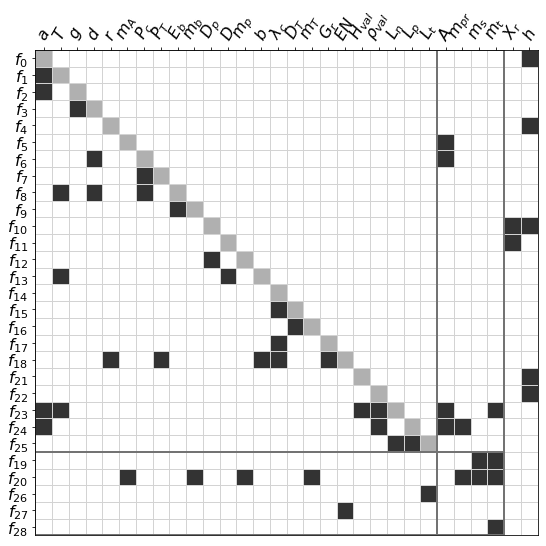

In [88]:
nodetyperepr_hsm = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc_hsm = namefromid(nodetyperepr_hsm)
render_incidence(edges_feedback_noparam, tree_feedback, namingfunc_hsm, figsize=(9,9));

In [89]:
#components = [Component.fromsympy(right, tovar=left, component=key) for key,(left,right) in eqs.items()]
#components += [Component.fromsympy(left-right, component=key, tovar=left if not left.forceunit else None, ignoretovar=True) for key,(left,right) in eqs.items()]

In [103]:
# for now we are not using the generated ordering
ordered_tree = tree_feedback 
ordered_edges = edges_feedback
comp_options = model.comp_options
comp_options = comp_options
var_options = model.var_options| {'m_s': [0,10], 'm_t':[0,10]}
solvers_options = model.solvers_options
#solvers_options[1] = {'solver': 'GS', 'maxiter':20} #without derivatives
solvers_options[1] = {'type': OPT, 'disp':True, 'optimizer': 'SLSQP'}
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [104]:
newcomps = transform_components(edges, edges_feedback, components, model.idmapping)

In [107]:
components = model.components+newcomps
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [108]:
prob, mdao_in0, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [109]:
#prob.set_solver_print(level=0)
#prob.set_solver_print(level=1, depth=1)
#prob.setup();

In [110]:
#prob.final_setup()

In [111]:
# prob.set_val('X_r', 0.5)
# prob.set_val('m_pr', 6)
# prob.set_val('A', 0.078)

In [112]:
#prob.set_val('m_s',prob.get_val('m_s'))
#prob.set_val('m_s',0.1)
#prob.set_val('m_t',0.1)

In [113]:
prob.run_driver()

Optimization terminated successfully    (Exit mode 0)
            Current function value: [5.80754331]
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 6
Optimization Complete
-----------------------------------


False

In [86]:
groups['s2'].iter_count

16

In [32]:
update_varval(model, prob, namingfunc, mdao_in0)

In [33]:
update_varval(model, prob, namingfunc)

In [34]:
#prob.run_model()

# Results

In [35]:
print_inputs(model, prob, namingfunc, mdao_in0)

$$h$$,400,km
$$X_r$$,5,m
$$A$$,0.051,m²
$$m_{pr}$$,3.836,kg


In [36]:
print_outputs(model, prob, namingfunc, rounding=3)

$$a$$,6778,km
$$T$$,92.558,min
$$g$$,0.11,
$$d$$,0.61,
$$r$$,2293.992,km
$$m_A$$,0.509,kg
$$P_c$$,12.725,W
$$P_T$$,0.725,W
$$E_b$$,115.866,kJ
$$m_b$$,0.232,kg
$$D_p$$,0.049,m


## Visualize structure

In [38]:
from datastructures.graphutils import SOLVER, namefromid, copy_dicts
nodetyperepr_hsm = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc_hsm = namefromid(nodetyperepr_hsm)

In [39]:
tree2 = copy_dicts(tree)
#tree2[1].update({6: 9, 7: 9, 9:1})

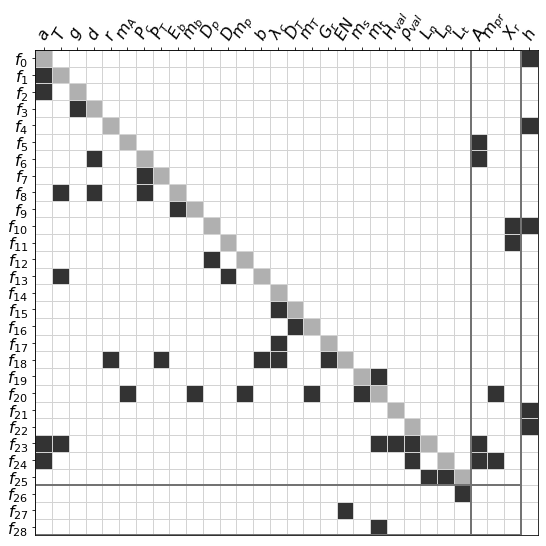

In [40]:
_, ax = render_incidence(edges_nopar, tree2, namingfunc_hsm, figsize=(9,9))

In [36]:
#plt.sca(ax)
#plt.savefig('satellite_default_hsm.png', dpi=200, bbox_inches='tight')

### Tree & Graph

In [92]:
from datastructures.nestedgraph import build_typedgraph
from datastructures.graphutils import draw_graph_graphical_props, all_solvers

In [90]:
from collections import defaultdict

In [108]:
graphs = build_typedgraph(edges, tree, nodetyperepr2)

In [156]:
Ein = defaultdict(list)
Eout = defaultdict(list)
Eout2 = dict()
solvers = all_solvers(tree2)
for key,var in graphs[1].edges():
    if key.name in solvers:
        Eout[key.name].append(var.name)
    else:
        Ein[var.name].append(key.name)
Eout2 = dict({idx:(idx,) for idx in range(2,9)})
for comp,varnames in Ein.items():
    Ein2[comp] = tuple(set(outcomp for var in varnames for outcomp,outvar in Eout.items() if var in outvar))
nodetyperepr3 = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc3 = namefromid(nodetyperepr3)

In [161]:
tree3 = OrderedDict([(elt,1) for elt in range(2,9)])
tree3[6] = 9
tree3[7] = 9

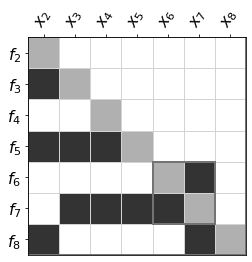

In [163]:
_, ax = render_incidence((Ein2, Eout2, dict()), (tree3,{9:1},dict()), namingfunc3)

In [104]:
Ein

defaultdict(list,
            {9: [m_A, m_b, m_T, m_p],
             8: [m_t, a, A, h, \mu, T],
             3: [A, T, d],
             4: [h, R],
             2: [h, \mu, R],
             5: [T, r, D, P_T]})

In [89]:
graphs[1].edges()

OutEdgeView([(m_A, 9), (9, m_t), (m_b, 9), (m_T, 9), (m_p, 9), (m_t, 8), (a, 8), (A, 8), (A, 3), (h, 8), (h, 4), (h, 2), (\mu, 8), (\mu, 2), (T, 8), (T, 5), (T, 3), (r, 5), (5, m_T), (D, 5), (P_T, 5), (R, 4), (R, 2), (4, D), (4, m_p), (3, m_A), (3, m_b), (3, P_T), (d, 3), (2, r), (2, T), (2, a), (2, d)])

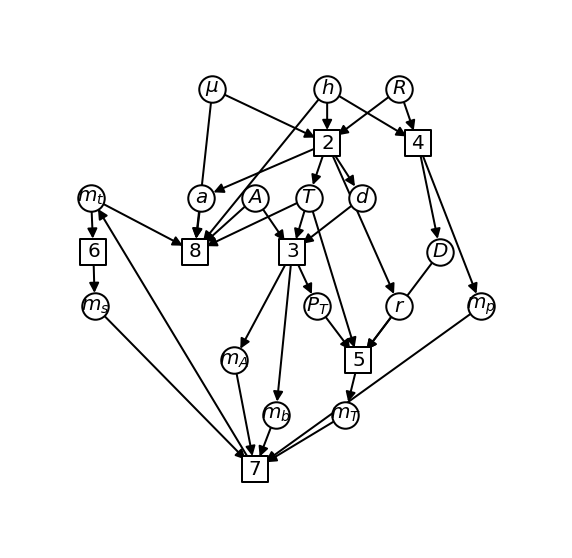

In [168]:
draw_graph_graphical_props(graphs[1], {}, prog='dot', figsize=(10,10))

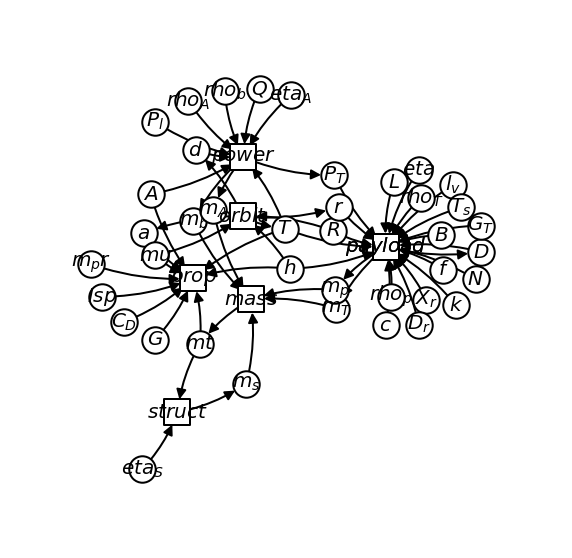

In [19]:
drawfull(graphs[m], model.eqs, figsize=(10,10))

# Min tear assign

In [20]:
not_input = ['H_{val}', r'\rho_{val}', 'm_p']#['m_p']#'d', r'\rho_{val}', 'L_p', 'H_{val}']
not_output = ['L_t','X_r','EN','h', 'm_s']#['h']#[r'm_{rz}', 'm_{r0}']

In [23]:
edges_for_solving = copy_dicts(edges_nopar)
eqns = list(edges_for_solving[1].keys())
allvrs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqns, {}))

In [24]:
min_assign_edges = edges_left_right 

In [38]:
#xsol,m = min_arc_set_assign(min_assign_edges, allvrs, eqns, not_input, not_output)
xsol, m = min_max_scc2(min_assign_edges, allvrs, eqns)

In [39]:
selected = dict((right, left) for left, right in edges_left_right if (left,right) in min_assign_edges and xsol[left, right] > 0.5)

In [42]:
edges_minassign, tree_minassign = reformulate(edges, tree, outset_initial, selected, root_solver_name=1, mdf=True)
edges_minassign_noparam = edges_no_param(model, edges_minassign)

In [43]:
#tree_minassign = tree_minassign[0], tree_minassign[1], {'m_s': 1}

In [44]:
# For topological sorting
#D = nx.DiGraph(dir_graph(edges_left_right, eqns, selected.items()))
#minassign_order = sort_scc(D, lambda x: x in eqns)

In [45]:
tree_minassign

(OrderedDict([(4, 1),
              (5, 1),
              (12, 1),
              (14, 1),
              (19, 1),
              (0, 1),
              (10, 1),
              (21, 1),
              (22, 1),
              (15, 1),
              (17, 1),
              (1, 1),
              (2, 1),
              (11, 1),
              (16, 1),
              (23, 1),
              (3, 1),
              (13, 1),
              (6, 1),
              (7, 1),
              (8, 1),
              (18, 1),
              (9, 1),
              (20, 1),
              (24, 1),
              (25, 1)]),
 {},
 {})

### For designtree_mina only

In [48]:
var_tree = {'m_s': 'root'}
solver_tree = {}

In [49]:
Ftree_mina = OrderedDict([(next(iter(comp)),'root') for comp in minassign_order])
tree_mina = Ftree_mina, solver_tree, var_tree

In [50]:
Ein, Eout, Rin = edges
Eout_minassign = {}
Ein_minassign = {}
for comp in Eout.keys():
    if comp in selected:
        varname = selected[comp]
    else:
        varname = None
    Eout_minassign[comp] = (varname,)
    Ein_minassign[comp] = tuple(varn for varn in chain(Ein[comp],Eout[comp]) if varn!=varname)
edges_minassign = (Ein_minassign, Eout_minassign, Rin)
edges_minassign_nopar = edges_no_param(model, edges_minassign)

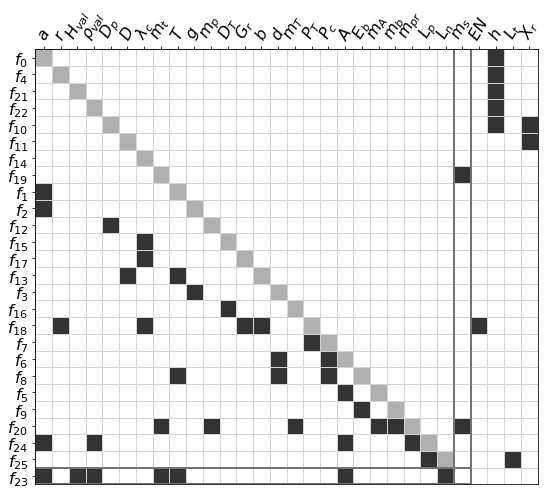

In [35]:
nodetyperepr_hsm = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc_hsm = namefromid(nodetyperepr_hsm)
render_incidence(edges_minassign_noparam, tree_minassign, namingfunc_hsm, figsize=(9,9));

In [52]:
# plt.sca(ax)
# #'satellite_minassign_hsm.png' <- for analysis
# plt.savefig('satellite_design_minassign_hsm.png', dpi=200, bbox_inches='tight')

In [53]:
components = model.components

In [54]:
newcomps = transform_components(edges, edges_minassign, components, model.idmapping)

In [55]:
newcomps

[(('Q', 'd', '\\eta_A', 'P_c'), 6, ('A',), 'P_c/(Q*\\eta_A*d)'),
 (('P_T', 'P_l'), 7, ('P_c',), 'P_l + P_T'),
 (('L', 'G_T', 'b', 'G_r', '\\lambda_c', 'k', 'T_s', 'r', 'EN'), 18, ('P_T',), '157.91367041743*L*T_s*k*EN*b*r**2/(G_T*G_r*\\lambda_c**2)'),
 (('\\eta_S', 'm_s'), 19, ('m_t',), 'm_s/\\eta_S'),
 (('m_s', 'm_T', 'm_t', 'm_A', 'm_b', 'm_p'), 20, ('m_{pr}',), '-m_A - m_T - m_b - m_p - m_s + m_t'),
 (('H_{val}', 'h'), 21, (None,), 'H_{val} - H(1000.0*h)'),
 (('C_D', 'T', 'A', 'a', 'L_n', '\\rho_{val}', 'm_t'), 23, ('H_{val}',), '6.2831853071796*C_D*A*L_n*\\rho_{val}*a**2/(T*m_t)'),
 (('L_p', 'L_t'), 25, ('L_n',), '-L_p + L_t')]

In [63]:
evalexpr(lookup_f(25).fxdisp, 'year')

dummy

In [57]:
lookup_f(1).evaldict({'a':1, r'\mu':2})

[DeviceArray(2341.60491035, dtype=float64)]

In [58]:
ordered_tree = tree_mina
ordered_edges = edges_minassign
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
#solvers_options['root2'] = {'solver': 'GS', 'maxiter':20}
#solvers_options['root'] = {'solver': 'GS', 'maxiter':20}
solvers_options['root'] = {'type': OPT, 'disp':True, 'optimizer': 'SLSQP'}
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [66]:
nodetyperepr = model.nametyperepr
nodetyperepr[SOLVER] = '{}'
namingfunc = namefromsympy(nodetyperepr)

In [67]:
mina_components = components+newcomps
lookup_f = get_f(mina_components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [68]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping, opt=False)

### Analysis

In [69]:
# prob.set_val('L_t', 1.4)
# prob.set_val('m_s', 300)
# prob.set_val('m_b', 300)
# prob.set_val('h', 400)

### Design

In [70]:
prob.set_val('L_t', 10)
prob.set_val('h', 400)
prob.set_val('EN', 10**(11.5/10))
prob.set_val('X_r', 5)
prob.set_val('m_s', 5)

In [71]:
prob.run_driver()

C:\Users\johan\miniconda3\envs\mdo\lib\site-packages\openmdao\core\total_jac.py:1539: DerivativesWarning:Constraints or objectives [('f26.neq26', inds=[0]), ('f27.neq27', inds=[0])] cannot be impacted by the design variables of the problem.


Optimization terminated successfully    (Exit mode 0)
            Current function value: [5.80755198]
            Iterations: 7
            Function evaluations: 12
            Gradient evaluations: 7
Optimization Complete
-----------------------------------


False

In [64]:
prob.run_model()

In [65]:
update_varval(model, prob, namingfunc)

In [66]:
#evalexpr(Ln)

In [67]:
#evalexpr(Hval*mt/(2*np.pi*C_D*A*rhoval*a**2)*T)

In [68]:
#evalexpr(Hval*mt/(2*np.pi)*T-Ln*C_D*A*rhoval*a**2)

In [72]:
print_inputs(model, prob, namingfunc, mdao_in0)

$$h$$,400,km
$$X_r$$,5,m
$$A$$,0.051,m²
$$m_{pr}$$,3.835,kg


In [74]:
print_outputs(model, prob, namingfunc, rounding=3)

$$a$$,6778,km
$$T$$,92.558,min
$$g$$,0.11,
$$d$$,0.61,
$$r$$,2293.992,km
$$m_A$$,0.509,kg
$$P_c$$,12.725,W
$$P_T$$,0.725,W
$$E_b$$,115.866,kJ
$$m_b$$,0.232,kg
$$D_p$$,0.049,m
